In [57]:
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
# https://www.tensorflow.org/decision_forests/tutorials/predict_colab
# https://www.tensorflow.org/decision_forests/tutorials/advanced_colab 

from google.cloud import bigquery

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)

2.12.0


In [58]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [59]:
model_tree_type=2# 1= xgboost  2=random forest
option_cate_feature=1 # the best formance

#labelCol='label_multi_severity'
labelCol='label_binary_severity'

metric="accuracy"

In [60]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

model_prefix="demo2"

bucket_name="gs://demo2-tf-incident-pongthorn"

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [62]:
if  labelCol=='label_multi_severity':
    if model_tree_type==1:
        _model=f'{model_prefix}_multi_gbt_tf_model'
    else:
         _model=f'{model_prefix}_multi_rf_tf__model'
else:
    if model_tree_type==1:
        _model=f'{model_prefix}_binary_gbt_tf_model'
    else:
         _model=f'{model_prefix}_binary_rf_tf_model'

if option_cate_feature==1:
    
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_binary_severity']
    else:
      unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_multi_severity']  
else:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_binary_severity']
    else:
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_multi_severity']   
    
    _model=f"{_model}_range_hour"
 


print(f"CateCols : {cateCols}")
print(f"NumbericCols : {numbericCols}")
print(f"UnusedCols : {unusedCols}")

model_gs_path=f"{bucket_name}/{_model}"
print(model_gs_path)
#model_local_path=_model

CateCols : ['sla', 'product_type', 'brand', 'service_type', 'incident_type']
NumbericCols : ['open_to_close_hour']
UnusedCols : ['id', 'severity_id', 'severity_name', 'range_open_to_close_hour', 'label_multi_severity']
gs://demo2-tf-incident-pongthorn/demo2_binary_rf_tf_model


# Load & Prepare Data

In [63]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [64]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912 entries, 0 to 2911
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  2912 non-null   int64  
 1   sla                    2912 non-null   object 
 2   product_type           2912 non-null   object 
 3   brand                  2912 non-null   object 
 4   service_type           2912 non-null   object 
 5   incident_type          2912 non-null   object 
 6   open_to_close_hour     2912 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 159.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  729 non-null    int64  
 1   sla                    729 non-null    object 
 2   product_type           729 non-null    o

# Explore & Visualize Target Class Label

In [65]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
print(classes)



[0, 1]


1(Critical) in Train=1538 and  1(Critical) in Test=395
Train: Ratio of 1(Critical) to AllLabels is 0.53
Test: Ratio of 1(Critical) to AllLabels is 0.54


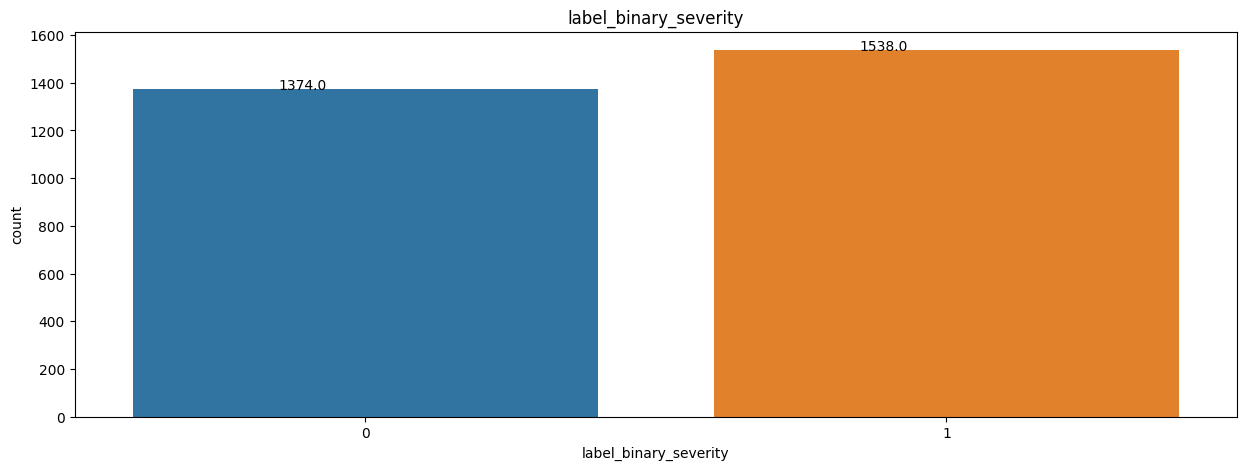

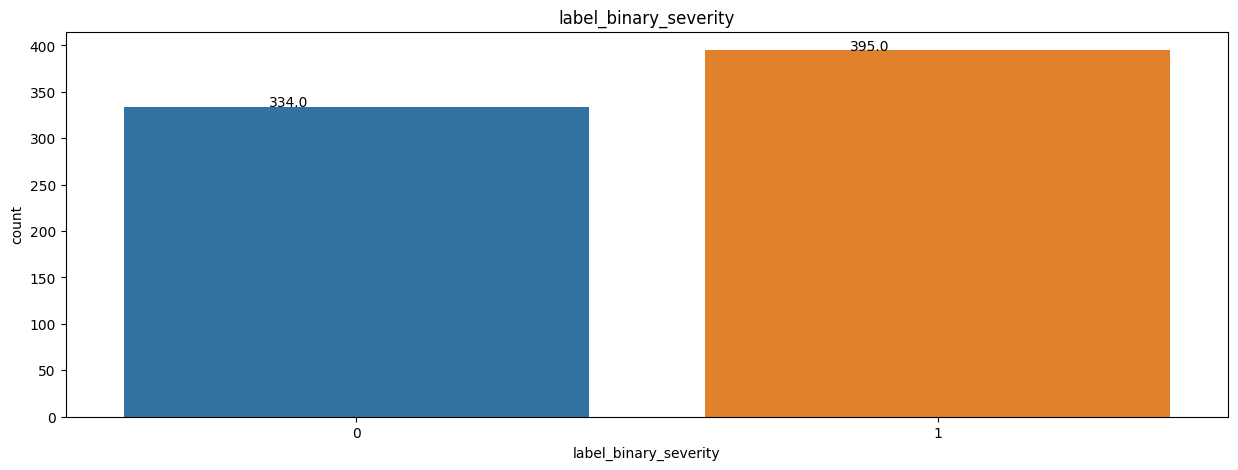

In [66]:
no_1_train=len(train.query(f"{labelCol}==1"))
no_1_test=len(test.query(f"{labelCol}==1"))
print(f"1(Critical) in Train={no_1_train} and  1(Critical) in Test={no_1_test}")

print(f"Train: Ratio of 1(Critical) to AllLabels is {round(no_1_train/len(train),2)}")
print(f"Test: Ratio of 1(Critical) to AllLabels is {round(no_1_test/len(test),2)}")

import seaborn as sns
import matplotlib.pyplot  as plt
def plot_label(df_):

    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df_,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol)
    plt.show()
        
plot_label(train)
plot_label(test)

In [67]:
train.tail(5)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
2907,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,306.583333
2908,1,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,2247.850000
2909,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,Configuration Change,119.616667
2910,1,24x7 4Hrs Response Time,Security,Trend Micro,Incident,Software,51.166667
2911,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,13.316667


In [68]:
test.tail()

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
724,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,2.000000
725,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333
726,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,96.483333
727,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,General Incident,0.333333
728,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,21.333333


# Convert dataframe to tensorflow dataset

In [69]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

# Build Model

In [70]:
# Specify the model.
if model_tree_type==1:
    print("GradientBoostedTreesModel")
    model=tfdf.keras.GradientBoostedTreesModel()
else:
    print("RandomForestModel")
    model = tfdf.keras.RandomForestModel()

model.fit(x=train_ds)

RandomForestModel
Use /var/tmp/tmp4zer4y1k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.202544. Found 2912 examples.
Training model...


2023-11-12 06:29:38.524795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2912]
	 [[{{node Placeholder/_0}}]]
[INFO 23-11-12 06:29:40.1084 UTC kernel.cc:1243] Loading model from path /var/tmp/tmp4zer4y1k/model/ with prefix 898a63dcc5b24f14


Model trained in 0:00:01.897784
Compiling model...


[INFO 23-11-12 06:29:40.5869 UTC decision_forest.cc:660] Model loaded with 300 root(s), 135716 node(s), and 6 input feature(s).
[INFO 23-11-12 06:29:40.5878 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-11-12 06:29:40.5883 UTC kernel.cc:1075] Use fast generic engine
2023-11-12 06:29:40.656171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2912]
	 [[{{node Placeholder/_1}}]]


Model compiled.


In [71]:
model.compile(metrics=[metric])
evaluation = model.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 168ms/step - loss: 0.0000e+00 - accuracy: 0.7929
loss: 0.0000
accuracy: 0.7929


2023-11-12 06:29:46.143923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [729]
	 [[{{node Placeholder/_6}}]]


# Inspect and debug decision forest models
## Model structure and feature importance

In [72]:

inspector=model.make_inspector()

print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

#[field for field in dir(inspector) if not field.startswith("_")]
# SUM_SCORE ,NUM_AS_ROOT

Model type: RANDOM_FOREST
Number of trees: 300
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Input features: ["brand" (4; #1), "incident_type" (4; #2), "open_to_close_hour" (1; #3), "product_type" (4; #4), "service_type" (4; #5), "sla" (4; #6)]


In [73]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH


# Model Self Evaluation

In [74]:
inspector.evaluation()

Evaluation(num_examples=2912, accuracy=0.7942994505494505, loss=0.6315602970154122, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

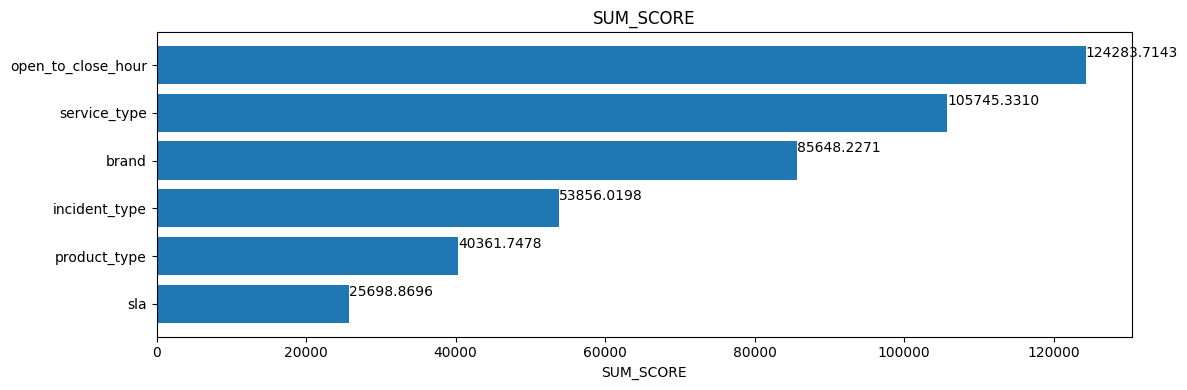

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "SUM_SCORE"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title(variable_importance_metric)
plt.tight_layout()
plt.show()

# Plot the model

In [76]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

# Plotting the training logs

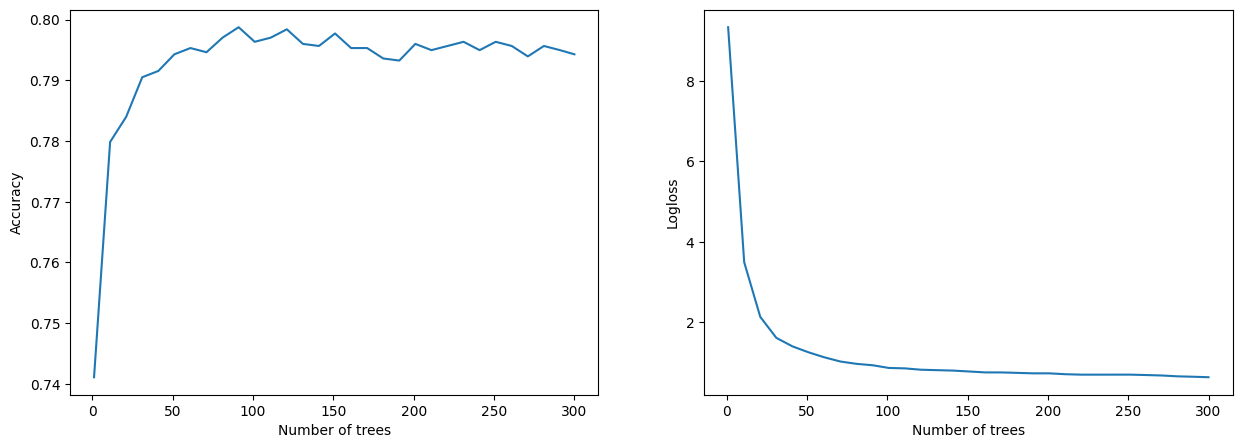

In [77]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()

# Save Model

In [78]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo2_binary_rf_tf_model/assets


INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo2_binary_rf_tf_model/assets
